In [1]:
from pathlib import Path
from XPINN import XPINN

In [31]:
import jax.numpy as np

file = Path("../data/advection_constraints.json")
xpinn = XPINN(file, np.tanh)

[<XPINN.PINN object at 0x17bac6d80>, <XPINN.PINN object at 0x17bb6aa20>, <XPINN.PINN object at 0x17e049f10>]
[Interface(indices=[0, 2], points=Array([[ 0.3       ,  1.        ],
       [ 0.2871795 ,  0.974359  ],
       [ 0.274359  ,  0.94871795],
       [ 0.26153848,  0.9230769 ],
       [ 0.24871795,  0.8974359 ],
       [ 0.23589744,  0.8717949 ],
       [ 0.22307692,  0.84615386],
       [ 0.21025641,  0.82051283],
       [ 0.1974359 ,  0.7948718 ],
       [ 0.18461539,  0.7692308 ],
       [ 0.17179488,  0.74358976],
       [ 0.15897436,  0.71794873],
       [ 0.14615385,  0.6923077 ],
       [ 0.13333334,  0.6666667 ],
       [ 0.12051282,  0.64102566],
       [ 0.10769231,  0.61538464],
       [ 0.0948718 ,  0.5897436 ],
       [ 0.08205128,  0.5641026 ],
       [ 0.06923077,  0.53846157],
       [ 0.05641026,  0.51282054],
       [ 0.04358974,  0.4871795 ],
       [ 0.03076923,  0.46153846],
       [ 0.01794872,  0.43589744],
       [ 0.00512821,  0.41025642],
       [-0.007692

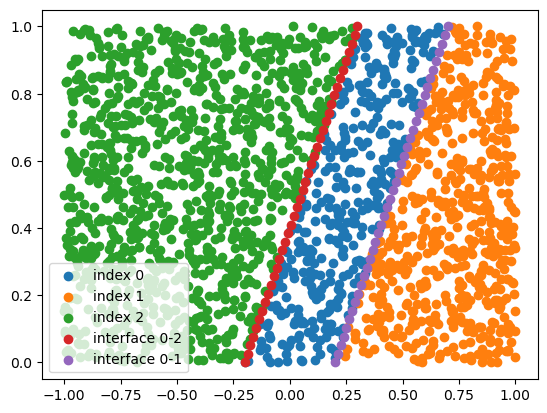

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

In [34]:
shapes = [[2, 10, 10, 1], [2, 50, 50, 1], [2, 100, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    pinn.init_params(shape)
    print([x[0].shape for x in pinn.params])

[(10, 2), (10, 10), (1, 10)]
[(50, 2), (50, 50), (1, 50)]
[(100, 2), (1, 100)]


In [39]:
for pinn in xpinn.PINNs:
    print([x[0].shape for x in pinn.params])
    print(pinn.interior.shape)
    pinn.model(pinn.params, pinn.interior)

[(10, 2), (10, 10), (1, 10)]
(372, 2)


TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (372,).